In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [83]:
df = pd.read_excel('/content/drive/MyDrive/merge_preprocessing_dano/files/final_accidents_data.xlsx')
df.head(5)

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   coordL                7888 non-null   float64       
 1   coordW                7888 non-null   float64       
 2   place                 7888 non-null   object        
 3   district              7888 non-null   object        
 4   DTPType               7888 non-null   object        
 5   date                  7888 non-null   object        
 6   real_date             7888 non-null   datetime64[ns]
 7   month                 7888 non-null   int64         
 8   season                7888 non-null   object        
 9   NVehicles             7888 non-null   int64         
 10  NPatricipants         7888 non-null   int64         
 11  NInjured              7888 non-null   int64         
 12  NFatal                7888 non-null   int64         
 13  additionalFactor  

В России существуют множество статей и гостов по определению материального ущерба от ДТП, например, есть структура EMPY для оценки вреда ТС, в которой содержаться статьи:

  * «О единой методике определения размера расходов на восстановительный ремонт в отношении поврежденного транспортного средства» N 432-П.
  * «О правилах проведения независимой технической экспертизы транспортного средства» N 433-П.
  * Электронная база стоимости запчастей.
Всего в документе 7 глав и 10 приложений-справочников. В главах подробно изложен порядок экспертиз после ДТП, процесс установки характера дефектов, описаны алгоритмы расчетов стоимости ремонта. В справочниках изложены:

1. — требования к проведению фотосъемки;
2. ⬇⬇⬇⬇⬇
3. — перечень типовых повреждений и рекомендации производителей по ремонту кузова (иномарки);
4. — цены на запасные части по регионам. Всего определено 13 зон, в каждой из которых действуют свои цены. Например, запчасти в Санкт-Петербурге и Москве значительно дороже, чем в среднем по России;
5. ⬇⬇⬇⬇⬇
6. — коэффициенты износа, дополнительные сведения;
7. — детали, для которых износ не предусмотрен (показатель износа — 0);
8. — данные по среднегодовому пробегу машины по регионам;
9. — коэффициенты эксплуатации;
10. — коэффициенты механических повреждений.

Или так же есть много других статей по поводу возмещения матереального ущерба, например, "Федеральный закон "Об обязательном страховании гражданской ответственности владельцев транспортных средств", но в нашем датсете данных для полной оценки материального ущерба от аварии нет. 
___
Изначально планировалось составить 2 индекса, индекс оценки материального ущерба, и индекс оценки тяжести аварии, но после попыток их создать оказалось, что такие индексы будут сильно влиять друг на друга и нельзя составить индекс материального ущерба, без учета человеческих потерь и травм. Исходя из этого мы решили объединить индексы в один общий индекс ущерба аварии, который назовем Рассчетный Индекс Тяжести Аварии или РИТА.
___
По поводу оценки человеческих потерь в РИТА-е мы опираемся на ОСАГО. Например, возьмем статью 12 п7. Там сказано 

"Размер страховой выплаты за причинение вреда жизни потерпевшего составляет:
475 тысяч рублей - выгодоприобретателям, указанным в пункте 6 настоящей статьи;
не более 25 тысяч рублей в счет возмещения расходов на погребение - лицам, понесшим такие расходы."
___
Для каждого пункта будем подсчитывать примерную стоимость единицы, если такое возможно.

в РИТА-е учтем столбцы:
  * NVehicles (число автомобилей участников) 100000;
  * NPatricipants (число участников) с малым коэф. из-за моральных компенсаций 500;
  * NInjured (число пострадавших) 1500;
  * NFatal (число погибших) 500000;
  * traffic_regime (изменение режима движения в результате ДТП) ;
  * neispravnosti;
  * privod, как еще однин столбец про сами ТС, скажем, что 4 колеса тормозят лучше 2;


Далее зададим коэффициенты этой регрессии.

Коэффициенты регрессии:
  * NVehicles  --  100;
  * NPatricipants  --  0.5;
  * NInjured  --  1.5;
  * NFatal  --  500;
  * traffic_regime  --  traffic_regime_index;
  * neispravnosti  --  neispravnosti_index;
  * privod  --  privod_index;

### traffic_regime_index

In [85]:
def replace_traf(string):
  if string == 'Режим движения не изменялся':
    return 0
  elif string == 'Движение частично перекрыто':
    return 50
  else:
    return 400

df['traffic_regime_index'] = [replace_traf(i) for i in df['traffic_regime']]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,50
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,50
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0


In [86]:
df.traffic_regime.value_counts()

Режим движения не изменялся     5139
Движение частично перекрыто     2730
Движение полностью перекрыто      19
Name: traffic_regime, dtype: int64

### neispravnosti_index

In [87]:
df.neispravnosti.value_counts()

Технические неисправности отсутствуют    7554
Имеются неисправности                     334
Name: neispravnosti, dtype: int64

In [88]:
def replace_neis(string):
  if string == 'Технические неисправности отсутствуют':
    return 0
  else:
    return 10

df['neispravnosti_index'] = [replace_neis(i) for i in df['neispravnosti']]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0,0
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,50,0
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0,0
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,50,0
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0,0


In [89]:
df.neispravnosti_index.value_counts()

0     7554
10     334
Name: neispravnosti_index, dtype: int64

### privod_index

In [90]:
df.privod.value_counts()

передний                             3913
задний,передний                       733
полный,передний                       706
задний                                652
передний,праворукий                   579
полный                                513
праворукий                            302
полный,праворукий                     120
полный,задний                          91
задний,праворукий                      79
полный,задний,передний                 61
Нет информации                         60
полный,передний,праворукий             42
задний,передний,праворукий             29
полный,задний,передний,праворукий       5
полный,задний,праворукий                3
Name: privod, dtype: int64

In [91]:
def replace_privod(string):
  index = 0
  if 'полный' in string:
    index += -5
  if 'задний' in string:
    index += 5
  if 'передний' in string:
    index += 10
  if 'праворукий' in string:
    index += 15
  return index

df['privod_index'] = [replace_privod(i) for i in df['privod']]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0,0,10
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,50,0,10
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0,0,15
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,50,0,10
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0,0,10


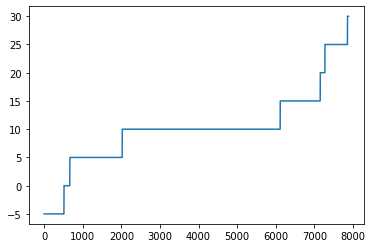

In [92]:
from copy import deepcopy
df1 = deepcopy(df)
plt.plot(range(7888), df1.sort_values(by='privod_index')['privod_index'].values)
plt.show()

## рассчет РИТА-а

In [112]:
def for_rita(NVehicles, NPatricipants, NInjured, NFatal, traffic_regime_index, neispravnosti_index, privod_index):
  return NPatricipants * 0.5 + NInjured * 1.5 + NFatal * 500 + (traffic_regime_index + neispravnosti_index + privod_index + NVehicles * 100) * 1.1

In [94]:
df.loc[6974, 'privod_index']

10

In [113]:
df['RITA'] = [for_rita(df.loc[i, 'NVehicles'], df.loc[i, 'NPatricipants'], df.loc[i, 'NInjured'], df.loc[i, 'NFatal'], df.loc[i, 'traffic_regime_index'], df.loc[i, 'neispravnosti_index'], df.loc[i, 'privod_index']) for i in range(len(df))]

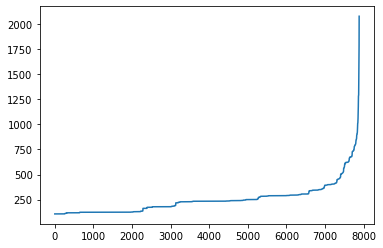

In [114]:
plt.plot(range(7888), df.sort_values(by='RITA')['RITA'].values)

In [115]:
df['FAIL'] = [df.loc[i, 'NPatricipants'] +  df.loc[i, 'NInjured'] * 1.5 +  df.loc[i, 'NFatal'] * 500 for i in range(len(df))]

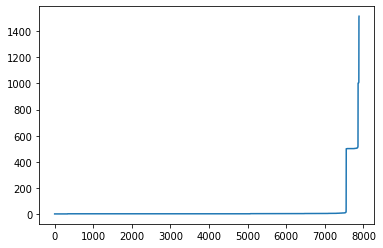

In [116]:
plt.plot(range(7888), df.sort_values(by='FAIL')['FAIL'].values)

In [117]:
df.groupby('violations').agg({'RITA':'mean', 'FAIL': 'mean'})

,RITA,FAIL
violations,,
Выезд на полосу встречного движения,368.689394,81.178030
"Выезд на полосу встречного движения в местах, где это запрещено",275.833333,4.916667
"Выезд на полосу встречного движения с разворотом, поворотом налево или объездом препятствия",275.777778,3.722222
Движение во встречном направлении по дороге с односторонним движением,236.250000,3.500000
Другие нарушения ПДД водителем,182.714286,39.142857
Другие нарушения ПДД водителями (не применяется с 12.2020),136.166667,3.166667
Иные нарушения,423.250000,254.000000
Нарушение правил буксировки,350.000000,5.500000
Нарушение правил обгона,288.500000,3.500000
